In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("Dataset.csv")
data

,date,start,finish,sunset,temperature,windy,clouds,rainy,snow,fog,...,Coyote,Opossum,Skunk,Wild_Hog,Red_Wolf,Gray_Fox,Rabbit,Bobcat,Area,deer_dens
0,10/16/2001,1/0/1900,1/0/1900,1/0/1900,46.0,True,3,False,False,False,...,0,0,0,0,0,0,0,0,470.0,117.500000
1,2/12/1997,1/0/1900,1/0/1900,1/0/1900,34.0,False,3,False,False,False,...,0,1,0,0,1,0,0,0,470.0,94.000000
2,1/15/2003,1/0/1900,1/0/1900,1/0/1900,28.0,False,1,False,False,False,...,0,0,0,0,0,0,0,0,470.0,78.333333
3,2/1/2000,1/0/1900,1/0/1900,1/0/1900,30.0,False,2,False,False,False,...,1,0,0,1,0,0,0,0,470.0,67.142857
4,1/5/1995,1/0/1900,NaN,NaN,25.0,False,1,False,False,False,...,0,0,0,0,0,0,0,0,470.0,58.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,11/4/1993,1/0/1900,1/0/1900,NaN,54.0,True,0,True,False,False,...,0,1,1,0,0,0,0,0,470.0,2.117117
211,3/29/1993,1/0/1900,1/0/1900,NaN,64.0,False,1,False,False,False,...,0,0,6,0,0,1,2,0,470.0,1.991525
212,5/11/1993,1/0/1900,1/0/1900,1/0/1900,65.0,False,2,False,False,False,...,0,0,0,0,0,0,0,0,470.0,1.843137
213,3/8/1993,1/0/1900,1/0/1900,1/0/1900,56.5,False,3,False,False,False,...,0,0,6,0,0,1,4,0,470.0,1.690647


In [3]:
data[["month","day","year"]] = data["date"].str.split("/",expand=True)

(-1.0, 50.0)

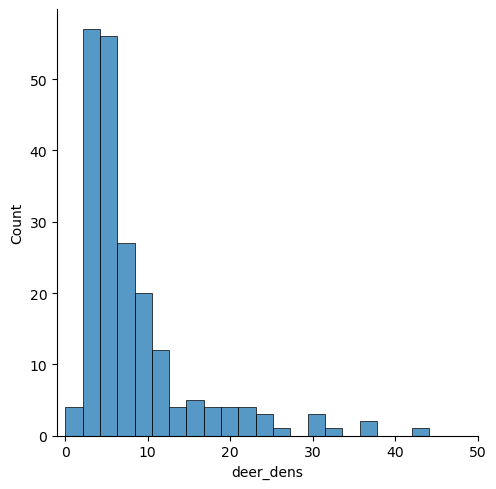

In [4]:
sns.displot(data['deer_dens']) # not normally distributed, skewed left
plt.xlim(-1, 50)

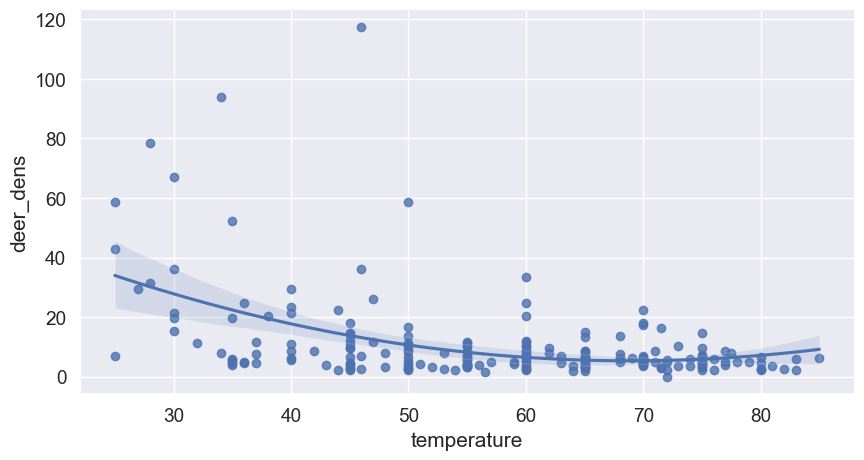

In [5]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'temperature', y = 'deer_dens', data = data, order=2)
plt.title('', fontsize=20)
plt.show()

Data exhibits heteroscedacity, i.e., uneven variance.  Variance is higher for lower temperatures.

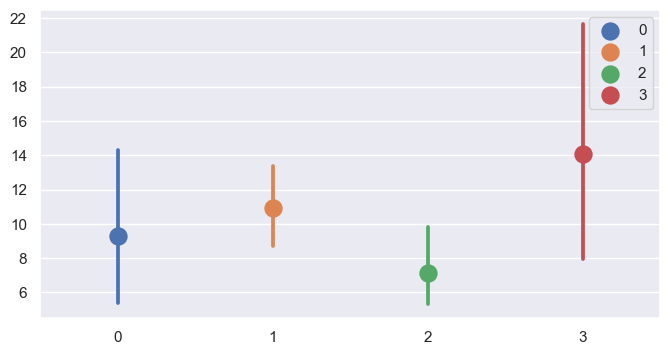

In [6]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="clouds", y="deer_dens", hue = "clouds", data=data, scale=1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

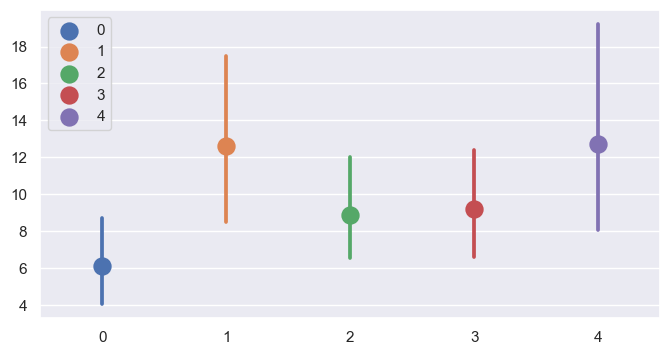

In [7]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="moon", y="deer_dens", hue = "moon", data=data, scale= 1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

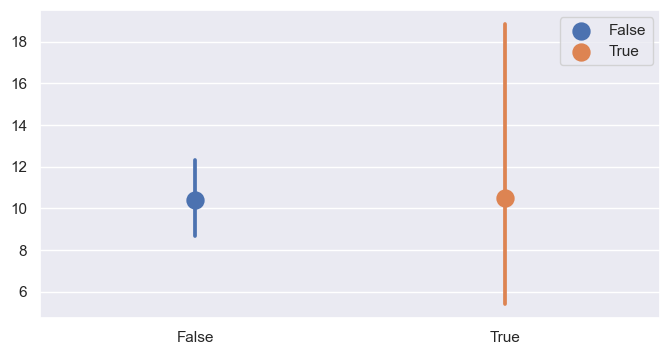

In [8]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="windy", y="deer_dens", hue = "windy", data=data, scale= 1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

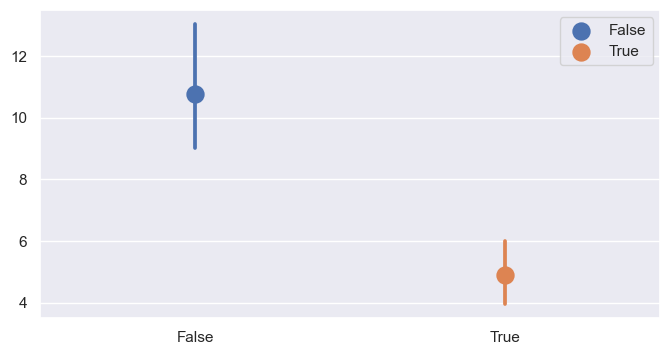

In [9]:
sns.set(rc={"figure.figsize":(8, 4)}, font_scale = 1) 
p = sns.pointplot(x="rainy", y="deer_dens", hue="rainy", data=data, scale= 1.5)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

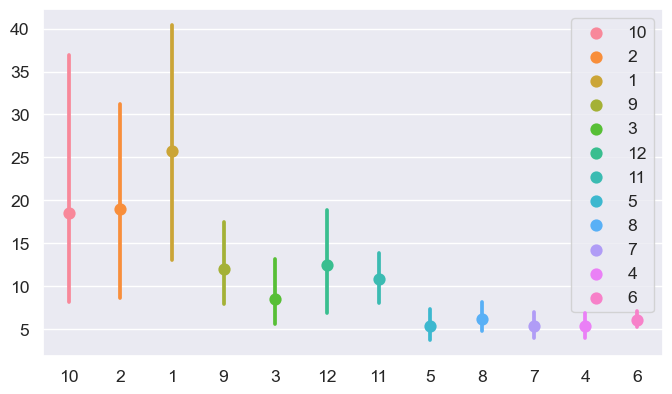

In [10]:
sns.set(rc={"figure.figsize":(8, 4.5)}, font_scale = 1.15) 
p = sns.pointplot(x="month", y="deer_dens", hue="month", data=data, scale= 1)
plt.xlabel("", size=30)
plt.ylabel("", size=30)
plt.legend(title = "", title_fontsize="30")

In [11]:
data['windy'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)
data['rainy'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)
data['snow'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)
data['fog'].replace(['FALSE', 'TRUE'],[0, 1], inplace=True)

In [12]:
data.drop(['date','start','finish','sunset','spotlight','notes',
           'conditions','observers','total_deer','Raccoon','Bear',
           'Coyote','Opossum','Skunk','Wild_Hog','Red_Wolf','Gray_Fox',
           'Rabbit','Bobcat','Area'],axis=1, inplace=True)

In [13]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
temperature : 0 NaN
windy : 0 NaN
clouds : 0 NaN
rainy : 0 NaN
snow : 0 NaN
fog : 0 NaN
moon : 0 NaN
deer_dens : 0 NaN
month : 0 NaN
day : 0 NaN
year : 0 NaN


C:\Users\wpson\AppData\Local\Temp\ipykernel_3552\2810399297.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":12})


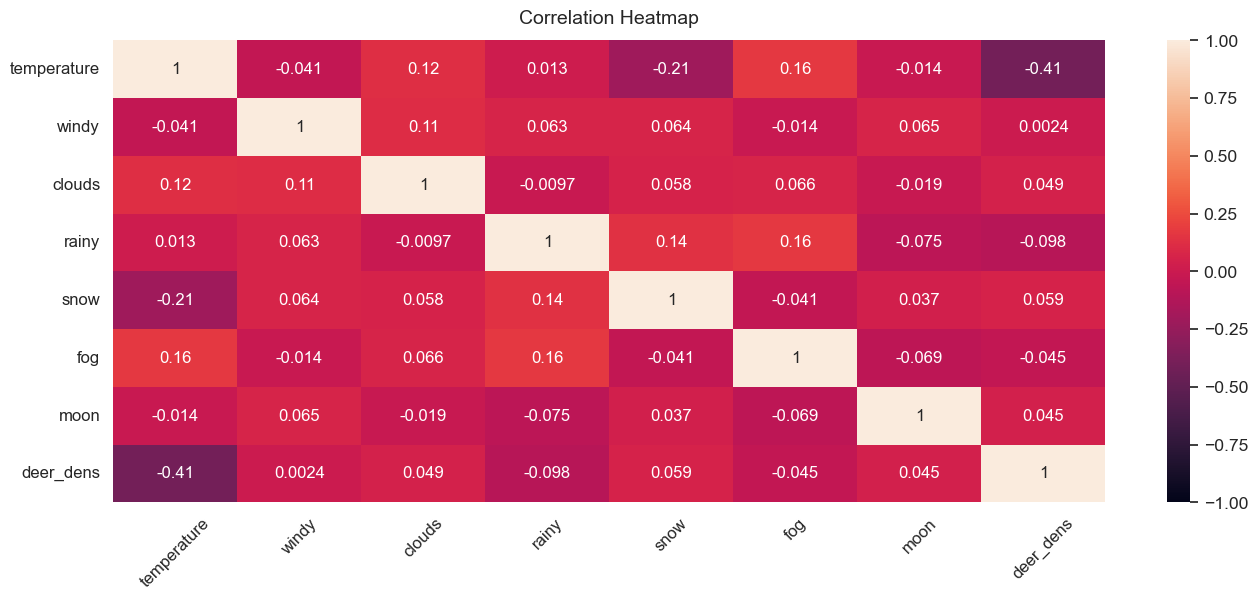

In [14]:
# Looking for multicollineatity among environmental variables.  Dropping highly correlated variables.

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":12})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

No multicollinearity detected, thus, no variables were dropped.

In [15]:
X = data[['month','temperature','windy','clouds','rainy','snow','fog','moon']] 
y = data['deer_dens']

Fit several linear regression models and select final model

In [16]:
lm1 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow + fog + moon', data = data).fit()
lm2 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow + fog', data = data).fit()
lm3 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow', data = data).fit()
lm4 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy', data = data).fit()
lm5 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds', data = data).fit()
lm6 = smf.ols(formula = 'deer_dens ~ month + temperature + windy', data = data).fit()
lm7 = smf.ols(formula = 'deer_dens ~ month + temperature', data = data).fit()

lm8 = smf.ols(formula = 'deer_dens ~ month + windy + clouds + rainy + snow + fog + moon', data = data).fit()
lm9 = smf.ols(formula = 'deer_dens ~ month + clouds + rainy + snow + fog + moon', data = data).fit()
lm10 = smf.ols(formula = 'deer_dens ~ month + rainy + snow + fog + moon', data = data).fit()
lm11 = smf.ols(formula = 'deer_dens ~ month + snow + fog + moon', data = data).fit()
lm12 = smf.ols(formula = 'deer_dens ~ month + fog + moon', data = data).fit()
lm13 = smf.ols(formula = 'deer_dens ~ month + moon', data = data).fit()

lm14 = smf.ols(formula = 'deer_dens ~ month + temperature + clouds + rainy + snow + fog + moon', data = data).fit()
lm15 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + rainy + snow + fog + moon', data = data).fit()
lm16 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + snow + fog + moon', data = data).fit()
lm17 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + fog + moon', data = data).fit()
lm18 = smf.ols(formula = 'deer_dens ~ month + temperature + windy + clouds + rainy + snow + moon', data = data).fit()

lm19 = smf.ols(formula = 'deer_dens ~ temperature', data = data).fit()


print("aic lm1: ", lm1.aic) 
print("aic lm2: ", lm2.aic)
print("aic lm3: ", lm3.aic)
print("aic lm4: ", lm4.aic)
print("aic lm5: ", lm5.aic)
print("aic lm6: ", lm6.aic)
print("aic lm7: ", lm7.aic) # lowest AIC score
print("aic lm8: ", lm8.aic) 
print("aic lm9: ", lm9.aic)
print("aic lm10:", lm10.aic)
print("aic lm11:", lm11.aic)
print("aic lm12:", lm12.aic)
print("aic lm13:", lm13.aic) 
print("aic lm14:", lm14.aic)
print("aic lm15:", lm15.aic)
print("aic lm16:", lm16.aic)
print("aic lm17:", lm17.aic)
print("aic lm18:", lm18.aic)
print("aic lm19:", lm19.aic)  

aic lm1:  1719.8772911827743
aic lm2:  1718.1384387126184
aic lm3:  1716.1482380727177
aic lm4:  1715.1862783685567
aic lm5:  1715.5626448780035
aic lm6:  1714.9689478083294
aic lm7:  1713.0681760779087
aic lm8:  1746.6102270591643
aic lm9:  1745.2998233000465
aic lm10: 1744.2967796067903
aic lm11: 1745.306460117676
aic lm12: 1743.4250922532278
aic lm13: 1741.6259328743633
aic lm14: 1717.9678010388484
aic lm15: 1719.4161884127768
aic lm16: 1719.688975175576
aic lm17: 1718.935599700396
aic lm18: 1717.8951194099805
aic lm19: 1717.8935736685191


In [17]:
print("bic lm1: ", lm1.bic) 
print("bic lm2: ", lm2.bic)
print("bic lm3: ", lm3.bic)
print("bic lm4: ", lm4.bic)
print("bic lm5: ", lm5.bic)
print("bic lm6: ", lm6.bic)
print("bic lm7: ", lm7.bic)
print("bic lm8: ", lm8.bic) 
print("bic lm9: ", lm9.bic)
print("bic lm10:", lm10.bic)
print("bic lm11:", lm11.bic)
print("bic lm12:", lm12.bic)
print("bic lm13:", lm13.bic)
print("bic lm14:", lm14.bic)
print("bic lm15:", lm15.bic)
print("bic lm16:", lm16.bic)
print("bic lm17:", lm17.bic)
print("bic lm18:", lm18.bic)
print("bic lm19:", lm19.bic) # lowest BIC score

bic lm1:  1783.9194137171999
bic lm2:  1778.8099232189163
bic lm3:  1773.449084550888
bic lm4:  1769.1164868185992
bic lm5:  1766.1222152999185
bic lm6:  1762.1578802021168
bic lm7:  1756.8864704435682
bic lm8:  1807.2817115654623
bic lm9:  1802.6006697782168
bic lm10: 1798.2269880568329
bic lm11: 1795.8660305395908
bic lm12: 1790.6140246470152
bic lm13: 1785.4442272400229
bic lm14: 1778.6392855451463
bic lm15: 1780.0876729190747
bic lm16: 1780.3604596818739
bic lm17: 1779.607084206694
bic lm18: 1778.5666039162784
bic lm19: 1724.6348497247745


AIC and BIC analyses reported different models with the lowest score.  lm19 had the largest difference between the lowest score and the second lowest score, and thus it is the selected model.

In [18]:
lm19.summary() # Selected model has poor fit to data; R-squared: 0.171

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              deer_dens   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     43.83
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           2.86e-10
Time:                        18:00:56   Log-Likelihood:                -856.95
No. Observations:                 215   AIC:                             1718.
Df Residuals:                     213   BIC:                             1725.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      33.6961      3.627      9.291      0.000      26.547      40.845
temperature    -0.4039      0.061     -6.621      0.000      -0.524      -0.284
==============================================================================
Omnibus:                      216.515   Durbin-Watson:                   0.400
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5442.227
Skew:                           3.999   Prob(JB):                         0.00
Kurtosis:                      26.314   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
pred = lm19.predict(X) # generating predictions from model
print(pred)

0      15.118391
1      19.964744
2      22.387920
3      21.580195
4      23.599508
         ...    
210    11.887490
211     7.848863
212     7.445000
213    10.877833
214     4.617961
Length: 215, dtype: float64


In [20]:
mae = mean_absolute_error(y, pred) # assessing mean absolute error (i.e., the average error between predicted values and actual values)
print(mae)

7.094693611983479


In [21]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

Using KFold cross validation to assess overfit

In [22]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [33.71313981  9.92110325  2.79086255  6.81310474  2.27792809  8.36664991
  6.32295766  4.63387333  4.66313328  6.56291899]
MAE average:  8.606567161014436


In [23]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [33.90606764 11.48985915  3.27303281  6.08065863  2.31717287 10.89948699
  4.51727639  4.11523787  4.35343507  6.00139174]
MAE average:  8.69536191600118


In [24]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wpson\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\sklearn.py", line 761, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\sklearn.py", line 286, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\sklearn.py", line 775, in <lambda>
    create_dmatrix=lambda **kwargs: DMatrix(nthread=self.n_jobs, **kwargs),
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\core.py", line 616, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py", line 707, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py", line 297, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py", line 242, in _transform_pandas_df
    raise ValueError(msg + ', '.join(bad_fields))
ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
                categorical type is supplied, DMatrix parameter `enable_categorical` must
                be set to `True`.month


MAEs are all over the place and the xgbr model failed to fit. 

Tuning hyperparameters via GridSearchCV

In [25]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [26]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [27]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [28]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="neg_mean_absolute_error",
                           verbose=1,
                           n_jobs=-1)

In [29]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [30]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='neg_mean_absolute_error', verbose=1)

In [31]:
pred_gs_rf = gs_rf.predict(X)
pred_gs_gb = gs_gb.predict(X)

mae_gs_rf = mean_absolute_error(y, pred_gs_rf)
mae_gs_gb = mean_absolute_error(y, pred_gs_gb)

print(mae_gs_rf) # lowest mae
print(mae_gs_gb)

2.6906411151128027
4.343778991771314


Assess if predictors have similar feature importance scores among models

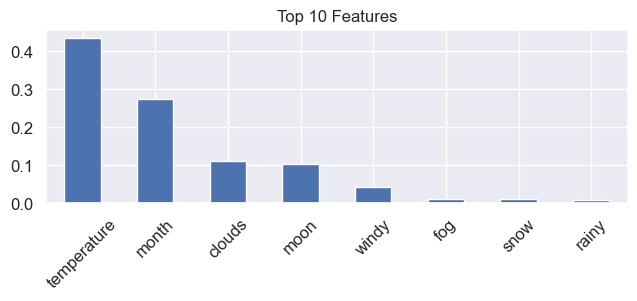

In [32]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 12
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()

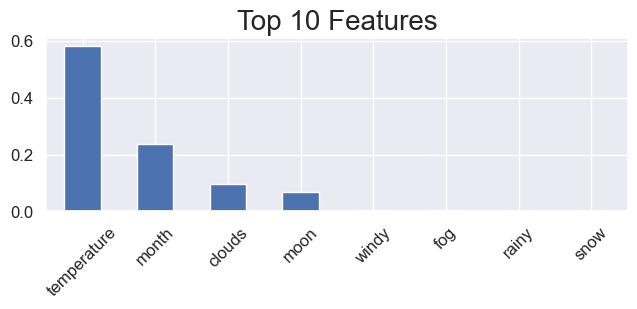

In [33]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
plt.figure(figsize=(7.5, 2.25))
feat_importances.nlargest(10).plot(kind='bar')
titlefont = 20
plt.title("Top 10 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.show()